# Goals

This notebook will map pout the burr pipelines that we will use to do document ingestion

## ENV Variables

In [1]:
# set your OpenAI API key
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

## Ingestion Flow DAG  

The Ingestion covers adding new files to the sql lite database.


At this level we will include:
- monitor: find new files
- validation: they are unique with a has
- ingest: move to raw stortage
- index: add to database


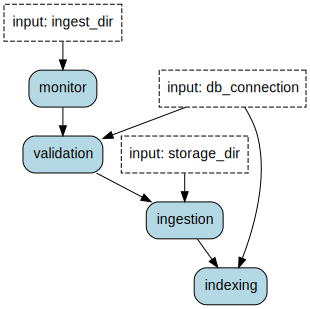

In [6]:
from burr.core import State, action, ApplicationBuilder
from ragnostic import ingestion

# Build and visualize graph/logic
(
    ApplicationBuilder()
    .with_actions(
        monitor=ingestion.monitor, 
        validation=ingestion.validation, 
        ingestion=ingestion.ingestion, 
        indexing=ingestion.indexing
    )
    .with_transitions(
        ("monitor", "validation"),
        ("validation", "ingestion"),
        ("ingestion", "indexing"),
    )
    .with_entrypoint("monitor")
    .build()
)

# Processing Flow DAG

The Processing covers metadata and document text content to the database.

At this level we will include:
- document_router: send to PDF or website processer
- text_extraction: extract text from pdf
- image_extraction: extract images and store in database
- table_extraction: extract tables and store in database
- metadata_extraction: update metadata


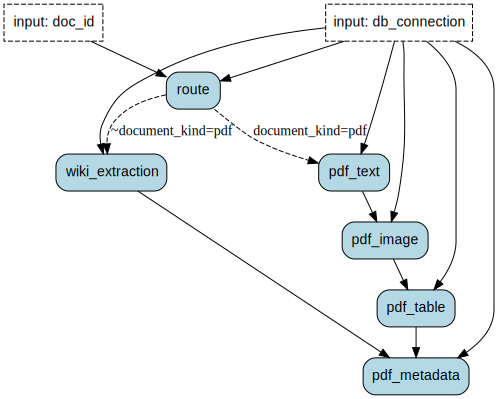

In [13]:
import pathlib
from burr.core import State, action, ApplicationBuilder
from burr.core import when

from ragnostic import utils

@action(reads=[], writes=["document_kind"])
def document_router(state: State, doc_id: str, db_connection) -> State:
    """Determine how to process the doc"""

    # Determine how to process the doc id based on the library entry
    # - Is it a PDF or a HTML?
    # - has it already been processed before?

    #Design Choices:
    # - should we load the document here or later?
    # - if loaded should we store it in the state as a python object?
    return state.update(document_kind='pdf')

@action(reads=[], writes=[])
def text_extraction(state: State, db_connection) -> State:
    """extract text"""
    # Extract text from pdf
    # - use the docling parser
    # - grab the raw text as is initially

    # Design Choices:
    # - should we store the docling parsed object in state and run various extraction steps on it?
    return state

@action(reads=[], writes=[])
def image_extraction(state: State, db_connection) -> State:
    """extract image"""

    # Extract and add images to database
    # - take docling object and put images with their metadata in the database
    
    # Design Choices:
    # - what inputs do we need? the docling objkect? the doc id and load it from database?
    
    return state

@action(reads=[], writes=[])
def table_extraction(state: State, db_connection) -> State:
    """extract table"""
    # Extract and add tables to database
    # - take docling object and put tables with their metadata in the database
    
    # Design Choices:
    # - what inputs do we need? the docling object? the doc id and load it from database?
    
    return state

@action(reads=[], writes=[])
def wikipedia_extraction(state: State, db_connection) -> State:
    """extract wikipedia"""

    # Design choices
    # Should we grab the HTML and store it then parse?
    # - should we just use the wikipedia API?
    # - should we do an image step later as well? 
    # - how would we identify images?
    return state

@action(reads=[], writes=[])
def metadata_extraction(state: State, db_connection) -> State:
    """extract table"""

    # Compile the metadata based on the previous steps
    # - does it have images, tables, etc?
    # - how many pages, etc
    # - status updates on the steps, flags, etc.
    
    return state
    
# Build and visualize graph/logic
(
    ApplicationBuilder()
    .with_actions(
        route=document_router, 
        pdf_text=text_extraction, 
        pdf_image=image_extraction, 
        pdf_table=table_extraction,
        pdf_metadata=metadata_extraction,
        wiki_extraction=wikipedia_extraction,
    )
    .with_transitions(
        ("route", "pdf_text", when(document_kind='pdf')),
        ("pdf_text", "pdf_image"),
        ("pdf_image", "pdf_table"),
        ("pdf_table", "pdf_metadata"),
        ("route", "wiki_extraction", ~when(document_kind='pdf')),
        ("wiki_extraction", "pdf_metadata"),
    )
    .with_entrypoint("route")
    .build()
)